# Catapult Project - Australian Geoscience Datacube API
Perform band maths and produce a Normalised Difference Vegetation Index (NDVI) file.

In [11]:
from pprint import pprint
%matplotlib inline
from matplotlib import pyplot as plt
import xarray
import datacube.api

In [12]:
dc = datacube.api.API()

In [13]:
alos2 = dc.get_dataset(product='gamma0', platform='ALOS_2', 
                      y=(-42.55,-42.57), x=(147.55,147.57), 
                      variables=['hh_gamma0', 'hv_gamma0'])

In [14]:
s1a = dc.get_dataset(product='gamma0', platform='SENTINEL_1A', 
                      y=(-42.55,-42.57), x=(147.55,147.57), 
                      variables=['vh_gamma0', 'vv_gamma0'])

In [15]:
hh = alos2.hh_gamma0
hv = alos2.hv_gamma0
vh = s1a.vv_gamma0
vv = s1a.vv_gamma0

Select the first time index and plot the first timeslice (only one timeslice in this example).

(array([  2.71500000e+03,   2.19400000e+03,   2.32700000e+03,
          2.57200000e+03,   2.58400000e+03,   2.50300000e+03,
          2.20000000e+03,   1.97800000e+03,   1.72200000e+03,
          1.35500000e+03,   1.17600000e+03,   1.00900000e+03,
          8.39000000e+02,   6.74000000e+02,   5.28000000e+02,
          4.55000000e+02,   3.96000000e+02,   3.11000000e+02,
          2.45000000e+02,   2.27000000e+02,   1.75000000e+02,
          1.55000000e+02,   1.23000000e+02,   9.80000000e+01,
          1.04000000e+02,   6.50000000e+01,   6.30000000e+01,
          5.60000000e+01,   5.20000000e+01,   3.20000000e+01,
          3.60000000e+01,   3.30000000e+01,   2.50000000e+01,
          1.40000000e+01,   2.00000000e+01,   1.40000000e+01,
          7.00000000e+00,   7.00000000e+00,   8.00000000e+00,
          7.00000000e+00,   1.30000000e+01,   1.00000000e+01,
          6.00000000e+00,   7.00000000e+00,   7.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   3.00000000e+00,
        

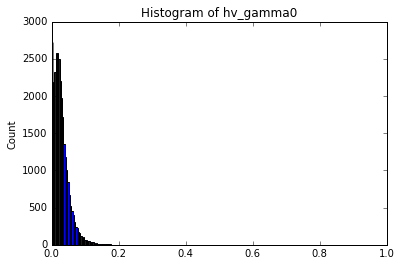

In [16]:
hv.isel(time=0).plot.hist(bins=256, range=(0.0,1.0))

Plot a band just for fun

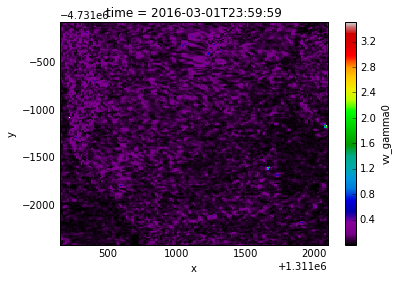

In [49]:
vv.isel(time=0).plot.imshow(cmap="spectral", clim=(0.0, 0.5))

We can also select a range on the spatial dimensions.

Insert some rsgislib segmentation magic below

The xarray can be turned into a Dataset, which can then be saved across all of the timeseries to a NetCDF file.

In [44]:
ds_vv = vv[:100,:100,:100].to_dataset(name='vv')
ds_vv.to_netcdf('vv.nc')

### Transposing dimensions

Merging two datasets

In [51]:
alos2_array = dc.get_dataset(product='gamma0', platform='ALOS_2', 
                      y=(-42.55,-42.57), x=(147.55,147.57), 
                      variables=['hh_gamma0', 'hv_gamma0'])
s1a_array = dc.get_dataset(product='gamma0', platform='SENTINEL_1A', 
                      y=(-42.55,-42.57), x=(147.55,147.57), 
                      variables=['vh_gamma0', 'vv_gamma0'])

sar_array = s1a_array.merge(alos2_array)
print (sar_array)

<xarray.Dataset>
Dimensions:    (time: 1, x: 156, y: 187)
Coordinates:
  * time       (time) datetime64[ns] 2016-03-01T23:59:59
  * y          (y) float64 -4.731e+06 -4.731e+06 -4.731e+06 -4.731e+06 ...
  * x          (x) float64 1.311e+06 1.311e+06 1.311e+06 1.311e+06 1.311e+06 ...
Data variables:
    vh_gamma0  (time, y, x) float32 0.0164571 0.0410914 0.0317888 0.0190076 ...
    vv_gamma0  (time, y, x) float32 0.0891735 0.0691831 0.128744 0.122255 ...
    crs        int32 0
    hh_gamma0  (time, y, x) float32 0.0655217 0.143631 0.11165 0.116711 ...
    hv_gamma0  (time, y, x) float32 0.0378705 0.0161559 0.0106346 0.00677407 ...
Attributes:
    license: Creative Commons Attribution 4.0 International CC BY 4.0
    source: This data is a reprojection and retile of Landsat surface reflectance data from the USGS
    summary: These files are experimental, short lived, and the format will change.
    title: Experimental Data files From the Australian Geoscience Data Cube - DO NOT USE
    pr

We will clip and scale the image to improve the contrast of the visible bands.

In [61]:
fake_saturation = 0.05
clipped_sar = sar_array.where(sar_array<fake_saturation).fillna(fake_saturation)
max_val = clipped_sar.max(['y', 'x'])
scaled = (clipped_sar / max_val)

In [63]:
rgb = scaled.transpose('time', 'y', 'x')
rgb.dims

Frozen(SortedKeysDict({'y': 187, 'x': 156, 'time': 1}))

TypeError: Image data can not convert to float

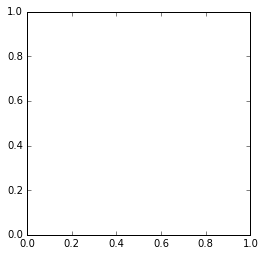

In [64]:
plt.imshow(rgb.isel(time=0))

In [ ]:
import matplotlib.image
matplotlib.image.imsave('vv_hh_vh.png', rgb.isel(time=16))

## Behind the scenes

The ndvi result is performed by chaining a series of operations together on a per-chunk basis. The execution tree, including the masking on the `nodata` value done by the API, ends up being the same for each chunk. The graph can be read from the bottom up, with the ouput array chunks at the top.
(Double-click the tree-graph image below to zoom)

In [ ]:
sar.data.visualize()

If we look at a single chunk, the NDVI calculation can be seen where the lines cross over to the `add` and `sub` circles.
Some optimizarion has taken place: the `div` operation has been combined with another inline function, and the other chunks have been discarded.

In [ ]:
partial = vv[0,0,0]
partial.data.visualize(optimize_graph=True)